<a href="https://colab.research.google.com/github/sadiqshittu/Alert-Repo/blob/main/ashittu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goals**: I will compare word frequencies within one author and across two authors, then check whether some words are preferred by one writer and less common for the other.

**Data sources** : I will use plain text books from Project Gutenberg, starting with Pride and Prejudice and Adventures of Huckleberry Finn.

**Method**: I will clean each file by removing the Gutenberg header and footer, convert to lower case, strip punctuation and numbers, then split into words. I will count words, compute relative frequencies, and visualize the largest differences. I will pick a single word "would", estimate its proportion in each book, and test whether the rates differ between books by the same writer and between different writers.



# Assignment 1

1. Compare word frequencies between two works of a single author.
1. Compare word frequencies between works of two authors.
1. Are there some words preferred by one author but used less frequently by another author?

Extra credit

1. The frequency of a specific word, e.g., "would" should follow a binomial distribution (each regular word in a document is a trial and with probability p that word is "would". The estimate for p is N("would")/N(regular word)). Do these binomial distributions for your chosen word differ significantly between books of the same author or between authors?

Project Gutenberg is a good source of for fiction and non-fiction.

E.g below are two most popular books from Project Gutenberg:
- Pride and Prejudice at http://www.gutenberg.org/ebooks/1342.txt.utf-8
- Adventures of Huckleberry Finn at http://www.gutenberg.org/ebooks/76.txt.utf-8

##Setup and helper functions

In [ ]:
# Requirements: requests, pandas, matplotlib are already in Colab
import re
import math
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
def fetch_text(url: str) -> str:
    """
    Download plain text from a URL and return it as a string.
    Uses a short user agent and utf8 decoding.
    Raises if the request fails.
    """
    headers = {"User-Agent": "Mozilla/5.0 for course work"}
    # Request the content with a time limit so it does not hang
    r = requests.get(url, headers=headers, timeout=60)
    # Set encoding to utf8 which matches Gutenberg text links ending in .utf-8
    r.encoding = "utf-8"
    # Return full text
    return r.text

In [ ]:
def strip_gutenberg_boilerplate(txt: str) -> str:
    """
    Remove the Project Gutenberg header and footer so we analyze only the book.
    This searches for the START and END markers that Gutenberg inserts.
    If markers are missing we keep the whole text.
    """
    # Find the start marker block
    start_match = re.search(
        r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*",
        txt,
        re.IGNORECASE | re.DOTALL
    )
    # Find the end marker block
    end_match = re.search(
        r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*",
        txt,
        re.IGNORECASE | re.DOTALL
    )
    # Compute slice boundaries
    start = start_match.end() if start_match else 0
    end = end_match.start() if end_match else len(txt)
    # Return the core book text
    return txt[start:end]

In [ ]:
def tokenize_words(txt: str):
    """
    Convert text to lower case and split into word tokens.
    Keeps letters and apostrophes so contractions stay together.
    """
    # Lowercase to merge variants like The and the
    lower = txt.lower()
    # Extract word like pieces that contain letters and apostrophes
    tokens = re.findall(r"[a-z']+", lower)
    return tokens

In [ ]:
# A light stop word set to hide very common words when comparing
STOPWORDS = {
    "the","and","to","of","a","in","that","it","is","i","you","for","was","he","with","as","his",
    "on","be","at","by","she","or","from","this","but","not","are","have","had","they","her",
    "which","we","were","their","my","me","an","so","all","one","said","them","there","if",
    "when","what","who","will","would","your","do","no","more","out","up","about","into","than",
    "then","could","been","did","any","some","very","over","such","only","now","like","these",
    "may","upon","must","him","our","us","those"
}

def count_words(tokens):
    """
    Count how many times each token appears.
    Returns a Counter mapping word to count.
    """
    return Counter(tokens)

def rel_freq(counter: Counter):
    """
    Convert raw counts to relative frequencies.
    Returns a dictionary word to frequency and also the total word count.
    """
    total = sum(counter.values())
    freqs = {w: c / total for w, c in counter.items()}
    return freqs, total

def compare_books(counter1: Counter, counter2: Counter, min_total=5, remove_stop=True):
    """
    Build a table that compares two word count maps.
    Filters rare words using min_total and can remove stop words.
    Adds useful columns for differences and ratios.
    Returns the comparison DataFrame and the two totals.
    """
    # Union of words from both books so every word is considered
    words = set(counter1) | set(counter2)
    rows = []
    # Totals for normalization
    n1 = sum(counter1.values())
    n2 = sum(counter2.values())
    # Build rows word by word
    for w in words:
        # Skip stop words if requested
        if remove_stop and w in STOPWORDS:
            continue
        c1 = counter1.get(w, 0)
        c2 = counter2.get(w, 0)
        # Skip words that are too rare across the pair
        if c1 + c2 < min_total:
            continue
        rows.append((w, c1, c2))
    # Create a DataFrame with raw counts
    df = pd.DataFrame(rows, columns=["word","count_1","count_2"])
    # Add relative frequencies
    df["freq_1"] = df["count_1"] / n1
    df["freq_2"] = df["count_2"] / n2
    # Difference in frequency which can be positive or negative
    df["diff"] = df["freq_1"] - df["freq_2"]
    # Add a smoothed ratio to avoid divide by zero problems
    df["ratio"] = (df["count_1"] + 0.5) / (df["count_2"] + 0.5)
    # Log ratio is often easier to read for symmetric spread
    df["log_ratio"] = np.log(df["ratio"])
    # Absolute difference for sorting by size of effect
    df["abs_diff"] = df["diff"].abs()
    # Order by strongest absolute difference
    df = df.sort_values("abs_diff", ascending=False).reset_index(drop=True)
    return df, n1, n2

def plot_top_diff(df, title, topn=20):
    """
    Plot the top words by absolute frequency difference.
    Bars to the right favor the first book and to the left favor the second.
    """
    # Take the head then sort so bars read from low to high
    top = df.head(topn).sort_values("diff")
    plt.figure(figsize=(10, 6))
    # Horizontal bar chart gives readable labels
    plt.barh(top["word"], top["diff"])
    # Visual zero line to separate sides
    plt.axvline(0, linestyle="--", linewidth=1, color="black")
    plt.title(title)
    plt.xlabel("frequency difference")
    plt.tight_layout()
    plt.show()

def two_proportion_z_test(x1, n1, x2, n2):
    """
    Classic two proportion z test.
    x1 is count of target word in book 1
    n1 is total words in book 1
    x2 and n2 likewise for book 2
    Returns p1 p2 z p_value
    """
    # Proportion in book 1
    p1 = x1 / n1
    # Proportion in book 2
    p2 = x2 / n2
    # Pooled proportion for the null
    p_pool = (x1 + x2) / (n1 + n2)
    # Standard error under the null
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    # Protect against zero division if totals are odd
    if se == 0:
        return p1, p2, 0.0, 1.0
    # Compute z score
    z = (p1 - p2) / se
    # Two sided p using error function
    p_value = 2 * (1 - 0.5 * (1 + math.erf(abs(z) / math.sqrt(2))))
    return p1, p2, z, p_value

def ci_norm(p, n, z=1.96):
    """
    Simple normal approximation confidence interval for a proportion.
    Returns lower and upper bounds.
    """
    se = math.sqrt(max(p*(1-p), 0) / n)
    return max(0.0, p - z*se), min(1.0, p + z*se)


## Pick books and build counts

In [ ]:
# Define a small list of books with author title and source link
BOOKS = [
    {
        "key": "austen_pp",
        "author": "Jane Austen",
        "title": "Pride and Prejudice",
        "url": "https://www.gutenberg.org/ebooks/1342.txt.utf-8",
    },
    {
        "key": "austen_ss",
        "author": "Jane Austen",
        "title": "Sense and Sensibility",
        "url": "https://www.gutenberg.org/ebooks/161.txt.utf-8",
    },
    {
        "key": "twain_hf",
        "author": "Mark Twain",
        "title": "Adventures of Huckleberry Finn",
        "url": "https://www.gutenberg.org/ebooks/76.txt.utf-8",
    },
    {
        "key": "twain_ts",
        "author": "Mark Twain",
        "title": "The Adventures of Tom Sawyer",
        "url": "https://www.gutenberg.org/ebooks/74.txt.utf-8",
    },
]

# Hold raw text for each book
texts = {}
# Hold token list for each book
tokens_map = {}
# Hold word counter for each book
counters = {}
# Build a summary table as we go
summ_rows = []

# Loop through the selection and prepare data for each book
for b in BOOKS:
    print(f"Fetching {b['author']} - {b['title']}")
    # Download text
    raw = fetch_text(b["url"])
    # Remove Gutenberg wrappers
    core = strip_gutenberg_boilerplate(raw)
    # Tokenize into words
    tokens = tokenize_words(core)
    # Count words
    cnt = count_words(tokens)
    # Store results for later use
    texts[b["key"]] = core
    tokens_map[b["key"]] = tokens
    counters[b["key"]] = cnt
    # Save a simple summary row for quick inspection
    summ_rows.append({
        "key": b["key"],
        "author": b["author"],
        "title": b["title"],
        "total_words": sum(cnt.values()),
        "vocab_size": len(cnt)
    })

# Create a DataFrame with totals and vocabulary sizes
summary_df = pd.DataFrame(summ_rows)
summary_df


Fetching Jane Austen - Pride and Prejudice
Fetching Jane Austen - Sense and Sensibility
Fetching Mark Twain - Adventures of Huckleberry Finn
Fetching Mark Twain - The Adventures of Tom Sawyer


,key,author,title,total_words,vocab_size
0,austen_pp,Jane Austen,Pride and Prejudice,128565,6729
1,austen_ss,Jane Austen,Sense and Sensibility,120869,6313
2,twain_hf,Mark Twain,Adventures of Huckleberry Finn,117777,6096
3,twain_ts,Mark Twain,The Adventures of Tom Sawyer,74383,7295


##Same author comparison

In [ ]:
# Choose two books by the same author
# Here both are by Jane Austen
key_1 = "austen_pp"
key_2 = "austen_ss"

# Build the comparison table
df_same, n1_same, n2_same = compare_books(
    counters[key_1],
    counters[key_2],
    min_total=5,        # filter out very rare words across the pair
    remove_stop=True    # drop very common function words
)

# Show the first rows with the largest absolute differences
print(f"Comparing {key_1} vs {key_2}")
df_same.head(20)


Comparing austen_pp vs austen_ss


,word,count_1,count_2,freq_1,freq_2,diff,ratio,log_ratio,abs_diff
0,elinor,0,685,0.000000,0.005667,-0.005667,0.000729,-7.223296,0.005667
1,elizabeth,645,0,0.005017,0.000000,0.005017,1291.000000,7.163172,0.005017
2,mr,808,178,0.006285,0.001473,0.004812,4.529412,1.510592,0.004812
3,marianne,0,566,0.000000,0.004683,-0.004683,0.000883,-7.032624,0.004683
4,darcy,432,0,0.003360,0.000000,0.003360,865.000000,6.762730,0.003360
5,bennet,339,0,0.002637,0.000000,0.002637,679.000000,6.520621,0.002637
6,bingley,310,0,0.002411,0.000000,0.002411,621.000000,6.431331,0.002411
7,jane,302,1,0.002349,0.000008,0.002341,201.666667,5.306616,0.002341
8,edward,1,263,0.000008,0.002176,-0.002168,0.005693,-5.168588,0.002168
9,dashwood,1,252,0.000008,0.002085,-0.002077,0.005941,-5.125946,0.002077


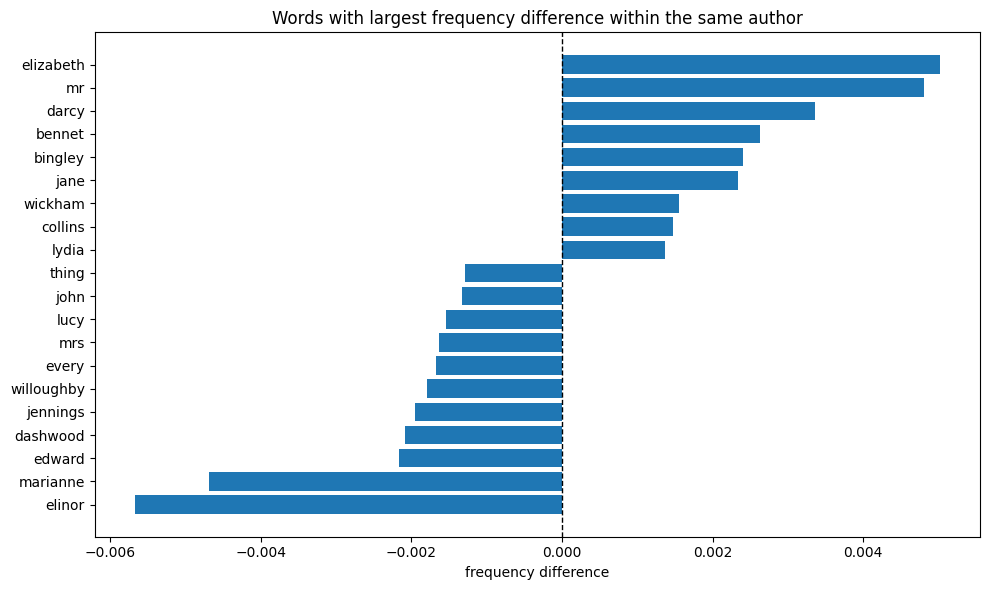

In [ ]:
# Visualize the strongest differences within the same author
plot_top_diff(
    df_same,
    title="Words with largest frequency difference within the same author",
    topn=20
)


##Different authors comparison

In [ ]:
# Choose a pair from different authors
key_a = "austen_pp"
key_b = "twain_hf"

# Build the cross author comparison
df_cross, n1_cross, n2_cross = compare_books(
    counters[key_a],
    counters[key_b],
    min_total=5,
    remove_stop=True
)

# Show the strongest differences
print(f"Comparing {key_a} vs {key_b}")
df_cross.head(20)


Comparing austen_pp vs twain_hf


,word,count_1,count_2,freq_1,freq_2,diff,ratio,log_ratio,abs_diff
0,t,21,2124,0.000163,0.018034,-0.017871,0.010120,-4.593239,0.017871
1,mr,808,23,0.006285,0.000195,0.006089,34.404255,3.538180,0.006089
2,says,15,638,0.000117,0.005417,-0.005300,0.024276,-3.718282,0.005300
3,got,25,624,0.000194,0.005298,-0.005104,0.040833,-3.198273,0.005104
4,elizabeth,645,0,0.005017,0.000000,0.005017,1291.000000,7.163172,0.005017
5,s,672,1135,0.005227,0.009637,-0.004410,0.592250,-0.523826,0.004410
6,down,79,485,0.000614,0.004118,-0.003503,0.163749,-1.809422,0.003503
7,darcy,432,0,0.003360,0.000000,0.003360,865.000000,6.762730,0.003360
8,jim,0,390,0.000000,0.003311,-0.003311,0.001280,-6.660575,0.003311
9,d,0,373,0.000000,0.003167,-0.003167,0.001339,-6.616065,0.003167


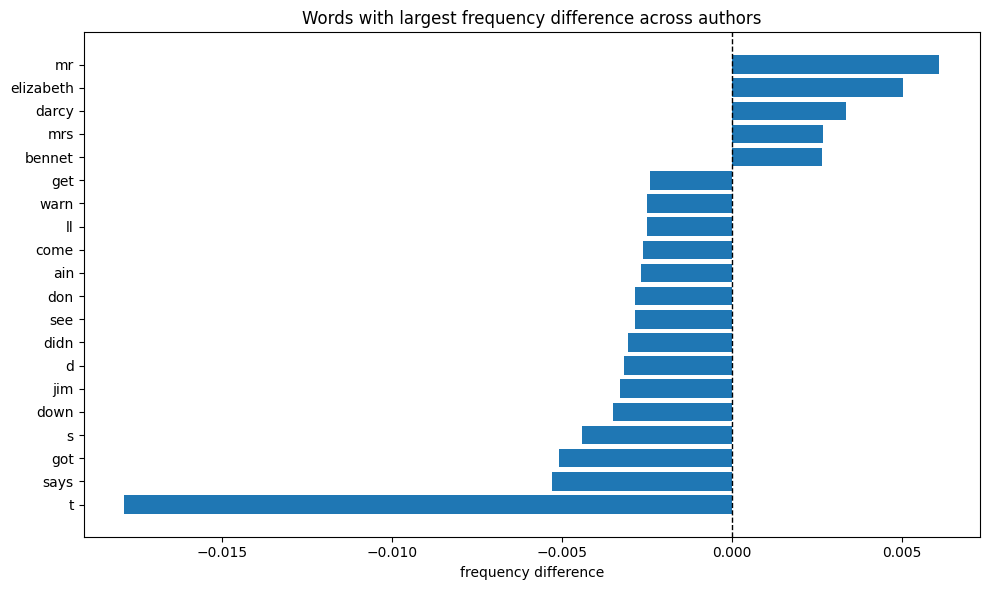

In [ ]:
# Plot the strongest differences across authors
plot_top_diff(
    df_cross,
    title="Words with largest frequency difference across authors",
    topn=20
)


##Tables of top preferences

In [ ]:
# Words that are much higher in the first selected book
top_for_a = (
    df_cross.sort_values("diff", ascending=False)
            .head(20)[["word","count_1","count_2","freq_1","freq_2","ratio","diff"]]
)

# Words that are much higher in the second selected book
top_for_b = (
    df_cross.sort_values("diff", ascending=True)
            .head(20)[["word","count_1","count_2","freq_1","freq_2","ratio","diff"]]
)

print("Higher in the first book")
display(top_for_a)

print("Higher in the second book")
display(top_for_b)


Higher in the first book


,word,count_1,count_2,freq_1,freq_2,ratio,diff
1,mr,808,23,0.006285,0.000195,34.404255,0.006089
4,elizabeth,645,0,0.005017,0.000000,1291.000000,0.005017
7,darcy,432,0,0.003360,0.000000,865.000000,0.003360
13,mrs,354,8,0.002753,0.000068,41.705882,0.002686
15,bennet,339,0,0.002637,0.000000,679.000000,0.002637
20,bingley,310,0,0.002411,0.000000,621.000000,0.002411
21,am,333,22,0.002590,0.000187,14.822222,0.002403
28,should,258,5,0.002007,0.000042,47.000000,0.001964
30,jane,302,49,0.002349,0.000416,6.111111,0.001933
34,miss,315,77,0.002450,0.000654,4.070968,0.001796


Higher in the second book


,word,count_1,count_2,freq_1,freq_2,ratio,diff
0,t,21,2124,0.000163,0.018034,0.010120,-0.017871
2,says,15,638,0.000117,0.005417,0.024276,-0.005300
3,got,25,624,0.000194,0.005298,0.040833,-0.005104
5,s,672,1135,0.005227,0.009637,0.592250,-0.004410
6,down,79,485,0.000614,0.004118,0.163749,-0.003503
8,jim,0,390,0.000000,0.003311,0.001280,-0.003311
9,d,0,373,0.000000,0.003167,0.001339,-0.003167
10,didn,0,361,0.000000,0.003065,0.001383,-0.003065
11,see,153,477,0.001190,0.004050,0.321466,-0.002860
12,don,7,343,0.000054,0.002912,0.021834,-0.002858


## target word

In [ ]:
# Pick the target word that you want to study
target_word = "would"

def book_word_stats(counter: Counter, word: str):
    """
    Compute count total and proportion for a given word in one book.
    Also returns a simple normal approximation confidence interval.
    """
    n = sum(counter.values())
    x = counter.get(word.lower(), 0)
    p = x / n if n else 0.0
    lo, hi = ci_norm(p, n) if n else (0.0, 0.0)
    return x, n, p, lo, hi

def report_pair(name1, c1, name2, c2, word):
    """
    Print a small report that compares the chosen word across two books.
    Includes counts totals proportions confidence intervals and a two proportion test.
    """
    # Stats for book 1
    x1, n1, p1, lo1, hi1 = book_word_stats(c1, word)
    # Stats for book 2
    x2, n2, p2, lo2, hi2 = book_word_stats(c2, word)
    # Two proportion z test for difference
    p1_, p2_, z, pval = two_proportion_z_test(x1, n1, x2, n2)

    # Pretty print the findings
    print(f"Word {word}")
    print(f"{name1}: count={x1}, total={n1}, p={p1:.6f}, 95pct CI=({lo1:.6f}, {hi1:.6f})")
    print(f"{name2}: count={x2}, total={n2}, p={p2:.6f}, 95pct CI=({lo2:.6f}, {hi2:.6f})")
    print(f"z={z:.4f}, two sided p={pval:.6g}")

# Same author test for the chosen word
name1 = "Austen Pride and Prejudice"
name2 = "Austen Sense and Sensibility"
report_pair(name1, counters["austen_pp"], name2, counters["austen_ss"], target_word)

print()

# Across authors test for the chosen word
name3 = "Austen Pride and Prejudice"
name4 = "Twain Huckleberry Finn"
report_pair(name3, counters["austen_pp"], name4, counters["twain_hf"], target_word)


Word would
Austen Pride and Prejudice: count=485, total=128565, p=0.003772, 95pct CI=(0.003437, 0.004108)
Austen Sense and Sensibility: count=515, total=120869, p=0.004261, 95pct CI=(0.003894, 0.004628)
z=-1.9292, two sided p=0.0537116

Word would
Austen Pride and Prejudice: count=485, total=128565, p=0.003772, 95pct CI=(0.003437, 0.004108)
Twain Huckleberry Finn: count=407, total=117777, p=0.003456, 95pct CI=(0.003121, 0.003791)
z=1.3073, two sided p=0.191103


##chosen word across all books

,author,title,p_hat,count,total
1,Jane Austen,Sense and Sensibility,0.004261,515,120869
0,Jane Austen,Pride and Prejudice,0.003772,485,128565
2,Mark Twain,Adventures of Huckleberry Finn,0.003456,407,117777
3,Mark Twain,The Adventures of Tom Sawyer,0.003240,241,74383


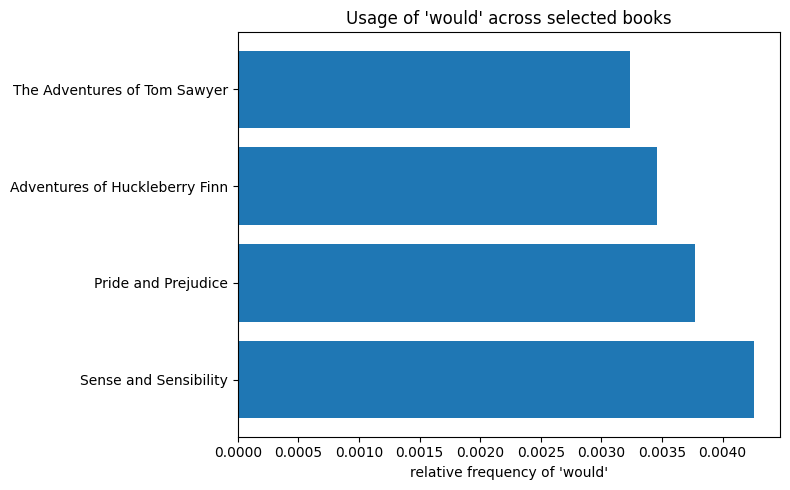

In [ ]:
# Build a small table with the relative frequency of the target word in each book
target_word = target_word.lower()

rows = []
for b in BOOKS:
    key = b["key"]
    x = counters[key].get(target_word, 0)                 # count of the word
    n = sum(counters[key].values())                       # total words
    p = x / n if n else 0.0                               # relative frequency
    rows.append({
        "author": b["author"],
        "title": b["title"],
        "p_hat": p,
        "count": x,
        "total": n
    })

# Create a DataFrame and order by frequency
p_df = pd.DataFrame(rows).sort_values("p_hat", ascending=False)
display(p_df)

# Plot a bar chart of usage rates for the chosen word
plt.figure(figsize=(8,5))
plt.barh(p_df["title"], p_df["p_hat"])
plt.xlabel(f"relative frequency of '{target_word}'")
plt.title(f"Usage of '{target_word}' across selected books")
plt.tight_layout()
plt.show()
